<a href="https://colab.research.google.com/github/plaban1981/Langchain_usecases/blob/main/Advanced_RAG_CohereReRanker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook shows how to use Cohere's rerank endpoint in a retriever. This builds on top of ideas in the ContextualCompressionRetriever.

In [1]:
import os
os.mkdir("Documenation")


## Install dependencies

In [7]:
!pip install -qU langchain openai cohere faiss-cpu tiktoken pypdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.6/276.6 kB 4.8 MB/s eta 0:00:00


In [17]:
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 59.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 89.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 28.4 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=55833b06f20a2ff88f2607054160c6a7a8588271a61caa31af6eb180c16eeb2d
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


## Set the required API keys

In [4]:
from getpass import getpass
os.environ["COHERE_API_KEY"] = getpass("Cohere API Key:")
os.environ["OPENAI_API_KEY"] = getpass("OpenAI API Key:")

Cohere API Key:··········
OpenAI API Key:··········


## Helper function for printing docs


In [6]:
def pretty_print_docs(docs):
    print(
        f"\n{'-' * 100}\n".join(
            [f"Document {i+1}:\n\n" + d.page_content for i, d in enumerate(docs)]
        )
    )

## Install required libraries

In [8]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.document_loaders import TextLoader
from langchain.vectorstores import FAISS
from langchain.document_loaders.pdf import PyPDFDirectoryLoader

##Load the pdf

In [9]:
pdf_folder_path = "/content/Documenation"
loader = PyPDFDirectoryLoader(pdf_folder_path)
docs = loader.load()

In [10]:
len(docs)

39

In [11]:
docs[1].page_content


'Introduction to Management  Studies  \n1 Introduction to Management Studies  \n \nAlan S. Gutterman  \n_______________  \n \n§1 Introduction  \n \nThis Research Paper  introduces  the central and important topic of “manage ment studies”. \nThe “study of management” covers a wide array of topics such as organizational t heory \nand behavior, strategic and human resources management, managerial functions and roles \nand identification and training of management skills.  The tools use d by practitioners of \nmanagement studies to collect and analyze information and disseminate fin dings within \nthe research community and to practicing managers are similarly diverse.  This Part \nincludes a brief  description of the history and evolution of man agement studies, a \ndaunting topic given that it is generally recognized that economic and milit ary activities \nhave been raising issues of planning, directing and control for thousands of years and that \none can find useful illustrations of m

## Split the documents into smaller chunks

In [12]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
texts = text_splitter.split_documents(docs)
print(len(texts))

368


## Define Embeddings

In [18]:
from langchain.embeddings import HuggingFaceBgeEmbeddings

model_name = "BAAI/bge-small-en-v1.5"
encode_kwargs = {'normalize_embeddings': True} # set True to compute cosine similarity

embeddings = HuggingFaceBgeEmbeddings(
    model_name=model_name,
    model_kwargs={'device': 'cpu'},
    encode_kwargs=encode_kwargs
)

## Set up the base vector store retriever

In [22]:
vectorstore = FAISS.from_documents(texts, embeddings)
retriever = vectorstore.as_retriever(search_kwargs={"k": 20})


## Retrieve the most relevant context from the vector store based on the query

In [23]:
query = "According to Kelly and Williams what is ethics?"
docs = retriever.get_relevant_documents(query)
pretty_print_docs(docs)

Document 1:

regarding ethics and values , role model ing, rewards for ethical behavior and swift and sure discipline for 
unethical behavior) and structures and systems that support and reinforce ethical behavior (i.e., 
organizational culture, code of ethics, ethics committee and chief ethics offi ce, ethics t raining and 
procedures for anonymous reporting of ethical concerns (“whistleblowing”)).  
 
Sources:  M. Kelly and C. Williams, “Business Ethics and Social Responsibility”, in M. Kelly and C.
----------------------------------------------------------------------------------------------------
Document 2:

individuals and groups use to analyze or interpret a situation and then decide what is right and the 
appropriate way to behave.  The concept of ethics can be viewed at several levels:  
 
77 Id. at 15 -16.
----------------------------------------------------------------------------------------------------
Document 3:

• The “practical” rule: An ethical decision is one that a 

## The Generation part of RAG Pipeline

In [29]:
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI
#
llm = ChatOpenAI(model_name="gpt-3.5-turbo-16k",temperature=0.1)
#
qa = RetrievalQA.from_chain_type(llm=llm,
                                 chain_type="stuff",
                                 retriever=retriever)


In [30]:
%%time
#
print(qa.run(query=query))

According to Kelly and Williams, ethics are the inner-guiding moral principles, values, and beliefs that individuals and groups use to analyze or interpret a situation and then decide what is right and the appropriate way to behave.
CPU times: user 249 ms, sys: 2.88 ms, total: 252 ms
Wall time: 3.15 s


## Reranking with CohereRerank

#### It is a 2 stage RAG
    - Stage 1 -keyword search followed by
    - Second stage - semantic Top K retrieval


* The recall performance for LLMs decreases as we add more context resulting in increased context window(**```context stuffing```**)

* Basic Idea behind reranking is to filter down the total number of documents into a fixed number .
* The reranker will rerank the records and get the most relevant items at the top and they can be sent to the LLM
* The Reranking offers a solution by finding those records that may not be within the top 3 results and put them into a smaller set of results that can be further fed into the LLM

In [31]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CohereRerank

##Set up the Reranker Retriever

* Here we have used ContextualCompressionRetriever in which we have wrapped both our base retriver and rerank compressor

## Contextual compression
One challenge with retrieval is that we usually you do not know the specific queries our document storage system will face when you ingest data into the system.

This means that the information most relevant to a query may be buried in a document with a lot of irrelevant text. Passing that full document through your application can lead to more expensive LLM calls and poorer responses.

**Contextual compression** is meant to fix this.

The idea is simple: **```instead of immediately returning retrieved documents as-is, you can compress them using the context of the given query, so that only the relevant information is returned.```**

**”Compressing”** here refers to both compressing the contents of an individual document and filtering out documents wholesale.

To use the Contextual Compression Retriever, you'll need:

* a base retriever

* a Document Compressor

#### Steps followed in Contextual Compression
* The Contextual Compression Retriever passes queries to the base retriever,

* It then takes the initial documents and passes them through the Document Compressor.
* The Document Compressor takes a list of documents and shortens it by reducing the contents of documents or dropping documents altogether.

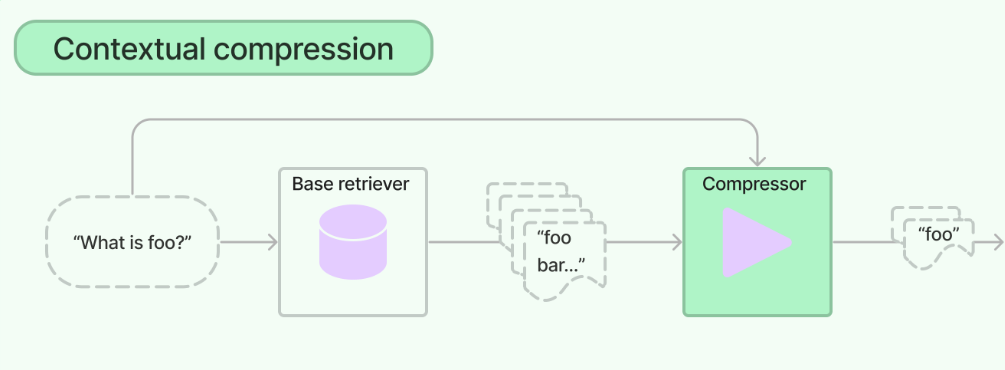

In [32]:
compressor = CohereRerank()
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever
)

## Print the documents retriever

In [33]:
compressed_docs = compression_retriever.get_relevant_documents(query)
pretty_print_docs(compressed_docs)

Document 1:

that helps another person or group and which is the “right thing to do” even if the action is not in the 
manager’s own self -interest.  In order for t he manager t o act effectively and appropriately in those 
instances, he or she needs to have a fundamental understanding of ethics and how ethical principles apply 
to managers and their organizations.  
 
According to Kelly and Williams, ethics are the inner -guiding moral  principles, values, and beliefs that
----------------------------------------------------------------------------------------------------
Document 2:

strive to find ways to deliver as much as possible to others  
• The “holism” principle: Remember to keep the “big picture” in mind at all times and recognize the 
importance of the personal side of employees in addition to their professional  activities,  the service 
side of business along with the profit side and the needs of the minority as well as the majority  
 
Kelly and Williams also offered eth

* So if we look above the compressor retriver has return only 3 most relevant contexts bassed on the query out of all the contexts returned by the base retriver.

## Generation - RAG Pipeline

In [34]:
qa = RetrievalQA.from_chain_type(llm=llm,
                                 chain_type="stuff",
                                 retriever=compression_retriever )

In [35]:
%%time
#
print(qa.run(query=query))

According to Kelly and Williams, ethics are the inner-guiding moral principles, values, and beliefs that strive to find ways to deliver as much as possible to others.
CPU times: user 246 ms, sys: 3.9 ms, total: 250 ms
Wall time: 2.42 s


####Note : Here we can see that the processing time of the response generation has come down to 2.42 seconds from 3.15 seconds when the reranking was not applied.